In [4]:
!pip install sentence-transformers openai-clip

In [5]:
!pip install faiss-cpu

In [6]:
!pip install -qU langchain-community faiss-cpu

# **Dataset**

In [1]:
## Access api secrets
import os
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [2]:
# download dataset
!kaggle datasets download "asaniczka/amazon-products-dataset-2023-1-4m-products"

Dataset URL: https://www.kaggle.com/datasets/asaniczka/amazon-products-dataset-2023-1-4m-products
License(s): ODC Attribution License (ODC-By)
 76% 75.0M/99.2M [00:00<00:00, 110MB/s]
100% 99.2M/99.2M [00:00<00:00, 141MB/s]


In [3]:
!unzip amazon-products-dataset-2023-1-4m-products.zip

Archive:  amazon-products-dataset-2023-1-4m-products.zip
  inflating: amazon_categories.csv   
  inflating: amazon_products.csv     


In [1]:
import pandas as pd
categories = pd.read_csv("data/amazon_categories.csv")
categories.sample(7)

,id,category_name
112,126,Oral Care Products
1,2,Fabric Decorating
175,189,Smart Home: WiFi and Networking
68,74,eBook Readers & Accessories
66,72,Office Electronics
167,181,Fish & Aquatic Pets
240,259,Virtual Reality Hardware & Accessories


In [2]:
products = pd.read_csv("data/amazon_products.csv")
products.head(2)

,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth
0,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",https://m.media-amazon.com/images/I/815dLQKYIY...,https://www.amazon.com/dp/B014TMV5YE,4.5,0,139.99,0.00,104,False,2000
1,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,https://m.media-amazon.com/images/I/81bQlm7vf6...,https://www.amazon.com/dp/B07GDLCQXV,4.5,0,169.99,209.99,104,False,1000


In [4]:
products.category_id.value_counts()

category_id
91     28619
84     24660
270    20846
114    19822
118    18994
       ...  
195       76
186       50
185       42
102       40
194       22
Name: count, Length: 248, dtype: int64

In [5]:
products[products['category_id'] == 118 ]['imgUrl'].to_list()

['https://m.media-amazon.com/images/I/61YjIUV77HL._AC_UL320_.jpg',
 'https://m.media-amazon.com/images/I/81gvD4LVipL._AC_UL320_.jpg',
 'https://m.media-amazon.com/images/I/81HqjSU64VL._AC_UL320_.jpg',
 'https://m.media-amazon.com/images/I/71mzzVgL91L._AC_UL320_.jpg',
 'https://m.media-amazon.com/images/I/81e8qiw1rEL._AC_UL320_.jpg',
 'https://m.media-amazon.com/images/I/71iCqzNUIfL._AC_UL320_.jpg',
 'https://m.media-amazon.com/images/I/71WkpiQE-4L._AC_UL320_.jpg',
 'https://m.media-amazon.com/images/I/81xwxFfF2VL._AC_UL320_.jpg',
 'https://m.media-amazon.com/images/I/61AtFGoi0JL._AC_UL320_.jpg',
 'https://m.media-amazon.com/images/I/51cB0B5UoSL._AC_UL320_.jpg',
 'https://m.media-amazon.com/images/I/91C1yUEq-fL._AC_UL320_.jpg',
 'https://m.media-amazon.com/images/I/71vTbo1+0OL._AC_UL320_.jpg',
 'https://m.media-amazon.com/images/I/61NScFNar+L._AC_UL320_.jpg',
 'https://m.media-amazon.com/images/I/71k9jvoKa2L._AC_UL320_.jpg',
 'https://m.media-amazon.com/images/I/61vk-1qOOUL._AC_UL320_.j

In [6]:
products["imgUrl"].shape

(1426337,)

# **DownSampling**

In [14]:
max_samples_per_category = 100  ## threshold

sampled_products = []
for cat, group in products.groupby("category_id"):
    if len(group) > max_samples_per_category:
        group_sample = group.sample(n=max_samples_per_category, random_state=42)
    else:
        group_sample = group
    sampled_products.append(group_sample)

sampled_products = pd.concat(sampled_products)
print(len(sampled_products))


24502


In [16]:
sampled_products.category_id.value_counts()

category_id
1      100
2      100
3      100
4      100
5      100
      ... 
195     76
186     50
185     42
102     40
194     22
Name: count, Length: 248, dtype: int64

# **Image Embeddings**

In [28]:
!pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
    --------------------------------------- 0.5/39.5 MB 357.1 kB/s eta 0:01:50
    --------------------------------------- 0.5/39.5 MB 357.1 kB/s eta 0:01:50
    --------------------------------------- 0.5/39.5 MB 357.1 kB/s eta 0:01:50
    --------------------------------------- 0.8/39.5 MB 409.3 kB/s eta 0:01:35
    --------------------------------------- 0.8/39.5 MB 409.3 kB/s eta 0:01:35
    --------------------------------------- 0.8/39.5 MB 409.3 kB/s eta 0:01:35
   - -------------------------------------- 1.0/39.5 MB 434.0 kB/s eta 0:01:29
   - ----------------------

In [18]:
import numpy as np
import clip
import torch.nn.functional as F
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from langchain_community.vectorstores import FAISS
import os
import faiss
import cv2
import torch
print(torch.__version__)

2.5.1


In [19]:
sampled_products['productURL'][7]

'https://www.amazon.com/dp/B07H515VCZ'

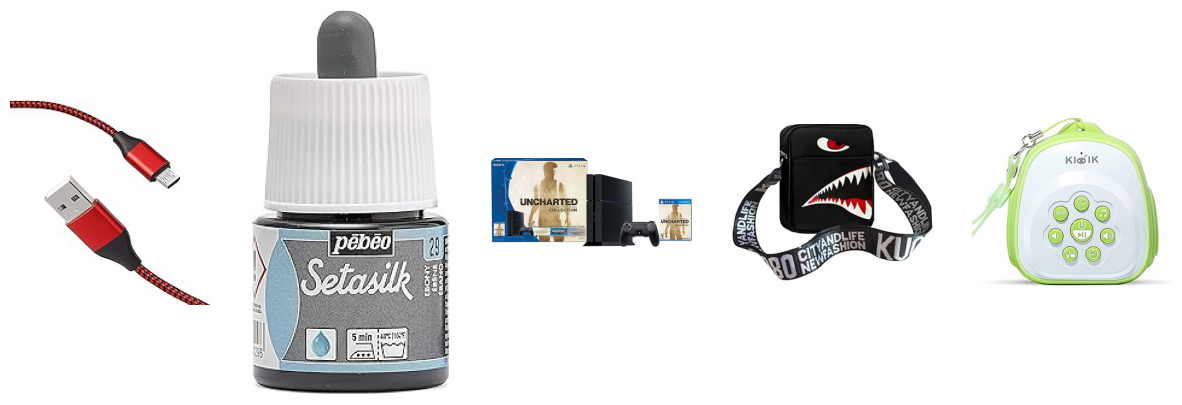

In [34]:
def display_images(image_urls, num_images=5):
    plt.figure(figsize=(15, 5))

    for i, url in enumerate(image_urls[:num_images]):
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))

            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.axis("off")
    plt.show()

if 'imgUrl' in sampled_products.columns:
    sample_urls = sampled_products['imgUrl'].sample(5).tolist()
    display_images(sample_urls)

In [34]:
sample_img = products['imgUrl'].sample().iloc[0]


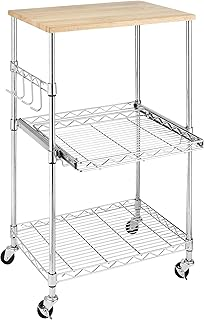

In [35]:
response = requests.get(sample_img, timeout=5)
img = Image.open(BytesIO(response.content)).convert("RGB")
img

In [10]:
sampled_products.duplicated().sum()

0

### **Load Clip Model**

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [22]:
model, preprocess = clip.load("ViT-B/32", device="cuda")

In [ ]:
from tqdm import tqdm

img_urls = sampled_products['imgUrl'].tolist()

img_embeddings = []
products_url = []

for url in tqdm(img_urls, desc="Processing images"):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img_tensor = preprocess(img).unsqueeze(0).to(device)

        with torch.no_grad():
            embeddings = model.encode_image(img_tensor).cpu().numpy().flatten()

        img_embeddings.append(embeddings)
        products_url.append(url)

    except Exception as e:
        print(f"Error processing {url}: {e}")

Processing images:   3%|█▋                                                       | 715/24502 [04:47<2:54:42,  2.27it/s]

In [38]:
dimension = 512  # CLIP embeddings of size 512
index = faiss.IndexFlatL2(dimension)

In [ ]:
img_embeddings = np.array(img_embeddings, dtype="float32")

In [ ]:
image_index = faiss.IndexFlatL2(dimension)  ### Create FAISS index
image_index.add(img_embeddings)

In [ ]:
faiss.write_index(image_index, "image_index.index")

# **Experiment with Batch Processing**

In [ ]:
# img_embeddings = []
# products_url = []

In [ ]:
# img_urls = products['imgUrl'].tolist()

# batch_size = 1000
# num_batches = len(img_urls) // batch_size + 1

# for i in range(num_batches):
#     batch_urls = img_urls[i * batch_size:(i + 1) * batch_size]
#     batch_embeddings = []
#     batch_product_urls = []

#     for url in batch_urls:
#         try:
#             response = requests.get(url)
#             img = Image.open(BytesIO(response.content)).convert("RGB")
#             img_tensor = preprocess(img).unsqueeze(0).to(device)

#             with torch.no_grad():
#                 embedding = model.encode_image(img_tensor).cpu().numpy().flatten()

#             batch_embeddings.append(embedding)
#             batch_product_urls.append(url)

#         except Exception as e:
#             print(f"Error processing {url}: {e}")

#     if batch_embeddings:
#         batch_embeddings = np.array(batch_embeddings, dtype="float32")
#         index.add(batch_embeddings)  # Add batch embeddings to FAISS index
#         products_url.extend(batch_product_urls)  # Collect valid URLs

#     print(f"Processed batch {i + 1}/{num_batches}")
